In [1]:
#установка библиотек, которых нет в стандартном пакете 
!pip install catboost
!pip install phik 
!pip install --upgrade lightgbm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# imports

In [56]:
import pandas as pd 
import numpy as np 

import warnings
warnings.filterwarnings("ignore")


from sklearn.compose import make_column_transformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import (
    GridSearchCV, cross_val_score,
    RandomizedSearchCV,
    train_test_split
)

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import (
    OneHotEncoder,
    OrdinalEncoder,
    StandardScaler, 
    LabelEncoder
)

from catboost import CatBoostRegressor
from catboost import Pool

import lightgbm as lgb

import phik
from phik.report import plot_correlation_matrix
from phik import report

import time 
from datetime import datetime

from matplotlib import pyplot as plt 
import seaborn as sns 
plt.style.use('dark_background')
plt.rcParams["figure.figsize"] = (15,5)

RANDOM_STATE = 42

#DATA_PATH = 'autos.csv'
DATA_PATH = '/datasets/autos.csv'

<div class="alert alert-block alert-success">
<b>✔️ Успех:</b>

Импорт выглядит отлично 👍
</div>

# dq 

## first check 

In [3]:
df = pd.read_csv(DATA_PATH)

In [4]:
df.sample(5)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
334517,2016-03-22 20:45:43,1500,wagon,2001,manual,0,NaN,150000,6,petrol,ford,yes,2016-03-22 00:00:00,0,88400,2016-03-22 20:45:43
57357,2016-03-05 14:48:18,2900,bus,2004,manual,114,other,150000,4,gasoline,renault,no,2016-03-05 00:00:00,0,63128,2016-03-12 17:48:46
190892,2016-03-16 18:56:02,15898,bus,2006,manual,174,transporter,150000,9,gasoline,volkswagen,no,2016-03-16 00:00:00,0,99096,2016-04-01 06:44:38
57224,2016-03-15 13:58:19,3299,wagon,2002,manual,130,a4,150000,4,petrol,audi,yes,2016-03-15 00:00:00,0,65620,2016-03-17 08:11:52
352262,2016-03-16 15:38:40,13500,wagon,2010,auto,155,6_reihe,70000,3,petrol,mazda,no,2016-03-16 00:00:00,0,88079,2016-04-06 16:44:57


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [6]:
df['LastSeen'] = df['LastSeen'].astype('datetime64')
df['DateCrawled'] = df['DateCrawled'].astype('datetime64')
df['DateCreated'] = df['DateCreated'].astype('datetime64')
df.columns = [col.lower() for col in df.columns]

<div class="alert alert-block alert-success">
<b>✔️ Успех:</b> 👍
</div>

## NaN's

In [7]:
round(df.isnull().mean().sort_values(ascending=False)*100,2)

repaired             20.08
vehicletype          10.58
fueltype              9.28
gearbox               5.60
model                 5.56
datecrawled           0.00
price                 0.00
registrationyear      0.00
power                 0.00
kilometer             0.00
registrationmonth     0.00
brand                 0.00
datecreated           0.00
numberofpictures      0.00
postalcode            0.00
lastseen              0.00
dtype: float64

получается, что очень много пропусков в колонках repaired, venicletype, fueltype, gearbox, model. 

местами пропусков слишком много, чтобы просто так выкинуть, но и замазать средним не получится, признаки категориальные. 

лучше просто в датасете так и пропишем: неизвестно. станет отдельной категорией 

In [8]:
df['repaired'] = df['repaired'].fillna('unknown')
df['vehicletype'] = df['vehicletype'].fillna('unknown')
df['gearbox'] = df['gearbox'].fillna('unknown')
df['model'] = df['model'].fillna('unknown')
df['fueltype'] = df['fueltype'].fillna('unknown')

<div class="alert alert-block alert-success">
<b>✔️ Успех:</b>

Пропуски успешно заполнены 👍 Модели теперь не будут капризничать)
</div>

## EDA + features clean up 

In [9]:
display(df.select_dtypes(include='datetime').describe())
df.drop(df.select_dtypes(include='datetime').columns, axis = 1, inplace=True) 

,datecrawled,datecreated,lastseen
count,354369,354369,354369
unique,271174,109,179150
top,2016-03-24 14:49:47,2016-04-03 00:00:00,2016-04-06 13:45:54
freq,7,13719,17
first,2016-03-05 14:06:22,2014-03-10 00:00:00,2016-03-05 14:15:08
last,2016-04-07 14:36:58,2016-04-07 00:00:00,2016-04-07 14:58:51


в данных с датами особо нет аномалий, но выглядят они как данные о юзерах/объявлениях и на цену машины влиять не должны. 
лучше бы их удалить. 

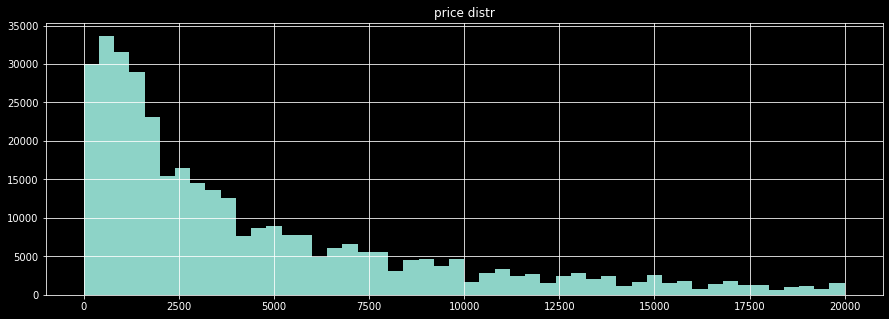

In [10]:
plt.title('price distr')
df.price.hist(bins=50)
plt.show()

In [11]:
cat_features = ['model', 'registrationyear']

In [12]:
price_grouped = df.groupby(cat_features).agg({'price':'mean'}).rename(columns = {'price':'avg_price'}).reset_index()

In [13]:
price_grouped[price_grouped['avg_price']==0]

,model,registrationyear,avg_price
0,100,1910,0.0
40,145,2002,0.0
56,147,2015,0.0
74,156,2007,0.0
125,1er,1980,0.0
...,...,...,...
4954,unknown,8455,0.0
4957,unknown,9229,0.0
4959,unknown,9996,0.0
5178,wrangler,1985,0.0


In [14]:
df = df.merge(price_grouped, on = cat_features, how = 'left')

In [15]:
def price_upd(row): 
  if row['price'] == 0:
    row['price'] = row['avg_price']
  else:
    pass
  return row

In [16]:
df = df.apply(lambda x: price_upd(x), axis = 1)

In [17]:
display(df.query('price==0').shape)
df = df.query('price != 0')

(88, 14)

в ценах много было моделей с 0 знаением цены -- выглядит очень странно, поэтому заполнил средним по модели и году выпуска, а где не получилось -- удалил: строк было совсем немного

In [18]:
df.vehicletype.value_counts(normalize=True)

sedan          0.258109
small          0.225313
wagon          0.183927
unknown        0.105696
bus            0.081210
convertible    0.057020
coupe          0.045611
suv            0.033846
other          0.009269
Name: vehicletype, dtype: float64

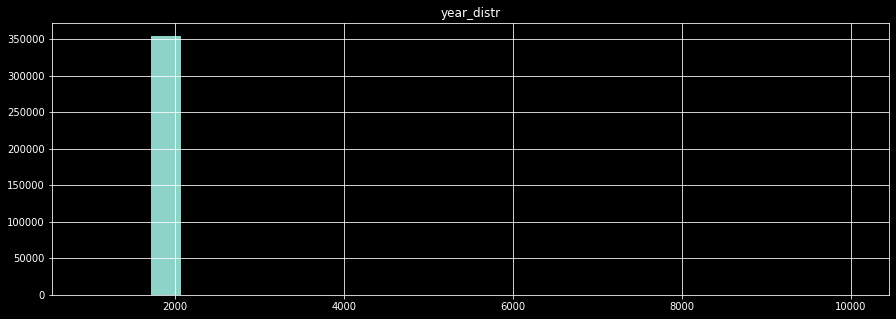

count    354281.000000
mean       2004.116605
std          85.146414
min        1000.000000
0%         1000.000000
1%         1980.000000
50%        2003.000000
90%        2012.000000
95%        2016.000000
99%        2018.000000
max        9999.000000
Name: registrationyear, dtype: float64

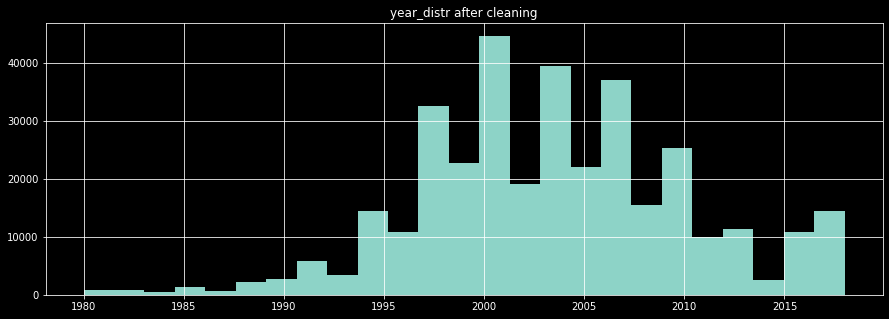

count    350738.000000
mean       2003.422275
std           6.608803
min        1980.000000
0%         1980.000000
1%         1987.000000
50%        2003.000000
90%        2012.000000
95%        2016.000000
99%        2018.000000
max        2018.000000
Name: registrationyear, dtype: float64

In [19]:
plt.title('year_distr')
df['registrationyear'].hist(bins = 25)
plt.show() 

display(df['registrationyear'].describe(percentiles=[0, 0.01, 0.5, 0.9, 0.95, 0.99]))

df = df.query('registrationyear > = 1980 and registrationyear <= 2018')

plt.title('year_distr after cleaning')
df['registrationyear'].hist(bins = 25)
plt.show() 

display(df['registrationyear'].describe(percentiles=[0, 0.01, 0.5, 0.9, 0.95, 0.99]))

есть какие-то нереально старые машины, которым практически тысяча лет в обед. 
их, пожалуй, лучше выкинуть из выборки

In [20]:
df['gearbox'].value_counts(normalize=True)

manual     0.758806
auto       0.187097
unknown    0.054097
Name: gearbox, dtype: float64

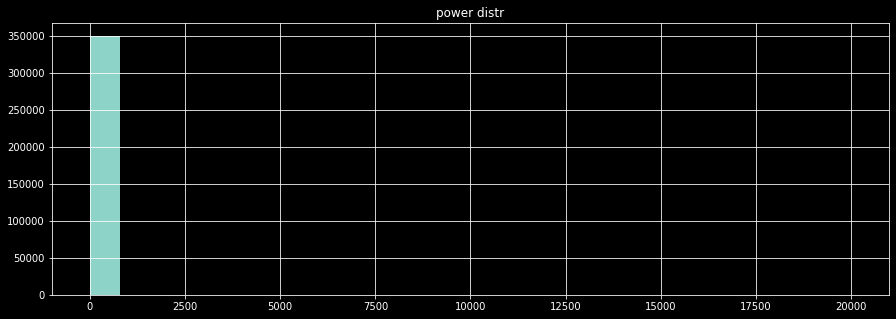

count    350738.000000
mean        110.425269
std         188.283177
min           0.000000
0%            0.000000
1%            0.000000
2%            0.000000
5%            0.000000
10%           0.000000
50%         105.000000
90%         179.000000
95%         218.000000
99%         300.000000
max       20000.000000
Name: power, dtype: float64

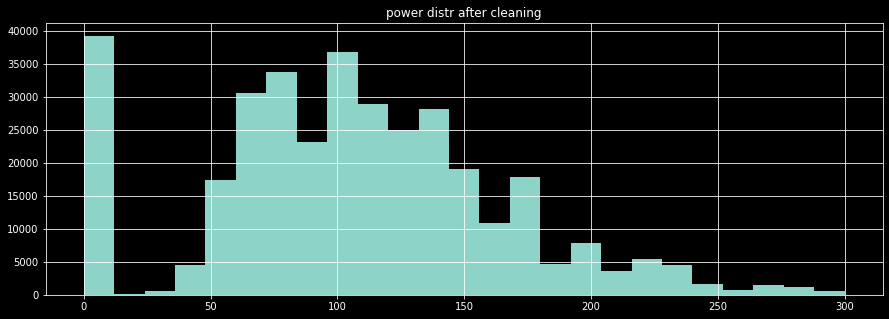

count    347308.000000
mean        104.777186
std          59.079175
min           0.000000
0%            0.000000
1%            0.000000
2%            0.000000
5%            0.000000
10%           0.000000
50%         103.000000
90%         177.000000
95%         204.000000
99%         258.000000
max         300.000000
Name: power, dtype: float64

In [21]:
plt.title('power distr')
df['power'].hist(bins = 25)
plt.show()
display(df['power'].describe(percentiles=[0, 0.01, 0.02, 0.1, 0.05,  0.5, 0.9, 0.95, 0.99]))

df = df.query('power <= 300') 

plt.title('power distr after cleaning')
df['power'].hist(bins = 25)
plt.show()
display(df['power'].describe(percentiles=[0, 0.01, 0.02, 0.1, 0.05,  0.5, 0.9, 0.95, 0.99]))


вот с мощностью тоже куча объявлений с 0, удалить не получится -- слишком много, лучше заполнить условным средним

In [22]:
df['power'] = np.where(df['power'] > 5, df['power'], df['power'] + df['power'].mean())

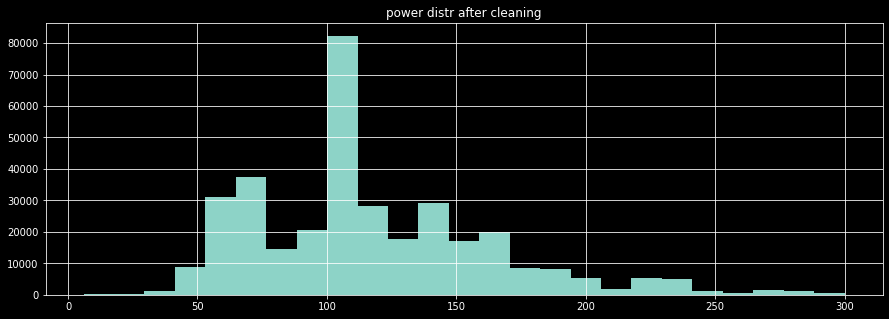

count    347308.000000
mean        116.589916
std          45.973059
min           6.000000
0%            6.000000
1%           45.000000
2%           50.000000
5%           55.000000
10%          60.000000
50%         104.777186
90%         177.000000
95%         204.000000
99%         258.000000
max         300.000000
Name: power, dtype: float64

In [23]:
plt.title('power distr after cleaning')
df['power'].hist(bins = 25)
plt.show()
display(df['power'].describe(percentiles=[0, 0.01, 0.02, 0.1, 0.05,  0.5, 0.9, 0.95, 0.99]))

с мощность тоже происходит странное, обработаем, но есть идея подумать над качеством датасета 

In [24]:
df['model'].value_counts(normalize=True).sort_values(ascending=False)*100

golf                  8.376139
other                 6.485022
3er                   5.633328
unknown               5.315743
polo                  3.752577
                        ...   
gl                    0.002303
i3                    0.002303
rangerover            0.001152
serie_2               0.000864
range_rover_evoque    0.000576
Name: model, Length: 249, dtype: float64

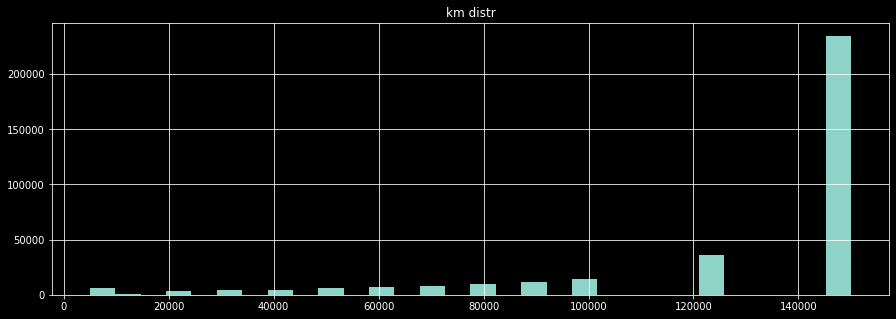

уникальных категорий километража 13


150000    0.675717
125000    0.103199
100000    0.041249
90000     0.032562
80000     0.028174
70000     0.024062
60000     0.020904
50000     0.017402
5000      0.016481
40000     0.013754
30000     0.012381
20000     0.011031
10000     0.003084
Name: kilometer, dtype: float64

In [25]:
plt.title('km distr')
df['kilometer'].hist(bins=30)
plt.show()

print('уникальных категорий километража', df['kilometer'].nunique())

df['kilometer'].value_counts(normalize='True')

интересно, что километраж выглядит скорее категориальной фичей, всего 13 уникальных значений, при этом видно, что большая часть машин с ощутимым пробегом

<AxesSubplot:>

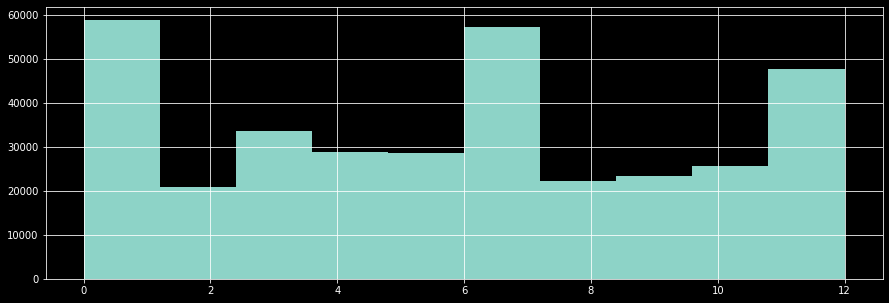

In [26]:
df['registrationmonth'].hist()

In [27]:
df['fueltype'].value_counts(normalize=True)

petrol      0.608253
gasoline    0.282798
unknown     0.091550
lpg         0.014396
cng         0.001607
hybrid      0.000662
other       0.000487
electric    0.000248
Name: fueltype, dtype: float64

In [28]:
df['brand'].value_counts(normalize=True).head(10)

volkswagen       0.219154
opel             0.113680
bmw              0.103749
mercedes_benz    0.088170
audi             0.082860
ford             0.071355
renault          0.051413
peugeot          0.031554
fiat             0.027117
seat             0.019801
Name: brand, dtype: float64

In [29]:
df['repaired'].value_counts(normalize=True)

no         0.698299
unknown    0.199630
yes        0.102071
Name: repaired, dtype: float64

в данных довольно много фирм и моделей, в основном представлены дизельные и бензиновые автомобили. 

после прпоусков в repaired получилось, около 20% машин без определенного статуса по ремонту. 

In [30]:
display(df['numberofpictures'].describe())
df.drop(['numberofpictures'], axis = 1, inplace = True)

count    347308.0
mean          0.0
std           0.0
min           0.0
25%           0.0
50%           0.0
75%           0.0
max           0.0
Name: numberofpictures, dtype: float64

в признаке df['numberofpictures'] только нулевые значения, его лучше удалить полностью

In [31]:
df['postalcode'].value_counts()

10115    795
65428    609
66333    341
32257    313
44145    310
        ... 
6638       1
29487      1
89368      1
95356      1
31096      1
Name: postalcode, Length: 8140, dtype: int64

с postal code все немного сложнее. с одной стороны -- это явно признак категориальный, с другой стороны парсить его на флаги невыгодно, слишком много уникальных значений. сам код может отражать город, а в разных городах цены на атвомобили могут отличаться в теории.

# feature correlation

In [32]:
phik_overview = df.phik_matrix()
phik_overview.round(2)

interval columns not set, guessing: ['price', 'registrationyear', 'power', 'kilometer', 'registrationmonth', 'postalcode', 'avg_price']


,price,vehicletype,registrationyear,gearbox,power,model,kilometer,registrationmonth,fueltype,brand,repaired,postalcode,avg_price
price,1.00,0.27,0.70,0.29,0.51,0.57,0.32,0.17,0.28,0.36,0.36,0.09,0.85
vehicletype,0.27,1.00,0.55,0.51,0.48,0.89,0.24,0.20,0.43,0.58,0.45,0.07,0.29
registrationyear,0.70,0.55,1.00,0.19,0.34,0.61,0.43,0.19,0.34,0.36,0.31,0.09,0.78
gearbox,0.29,0.51,0.19,1.00,0.48,0.62,0.07,0.27,0.34,0.51,0.48,0.09,0.25
power,0.51,0.48,0.34,0.48,1.00,0.80,0.13,0.14,0.27,0.63,0.20,0.09,0.46
model,0.57,0.89,0.61,0.62,0.80,1.00,0.44,0.20,0.55,1.00,0.33,0.21,0.73
kilometer,0.32,0.24,0.43,0.07,0.13,0.44,1.00,0.06,0.15,0.27,0.23,0.04,0.29
registrationmonth,0.17,0.20,0.19,0.27,0.14,0.20,0.06,1.00,0.20,0.11,0.30,0.05,0.14
fueltype,0.28,0.43,0.34,0.34,0.27,0.55,0.15,0.20,1.00,0.33,0.27,0.06,0.31
brand,0.36,0.58,0.36,0.51,0.63,1.00,0.27,0.11,0.33,1.00,0.16,0.18,0.42


In [33]:
phik_overview['price'].sort_values(ascending = False)

price                1.000000
avg_price            0.848960
registrationyear     0.698094
model                0.574773
power                0.509635
repaired             0.357874
brand                0.356514
kilometer            0.319545
gearbox              0.292771
fueltype             0.279460
vehicletype          0.274921
registrationmonth    0.170379
postalcode           0.092852
Name: price, dtype: float64

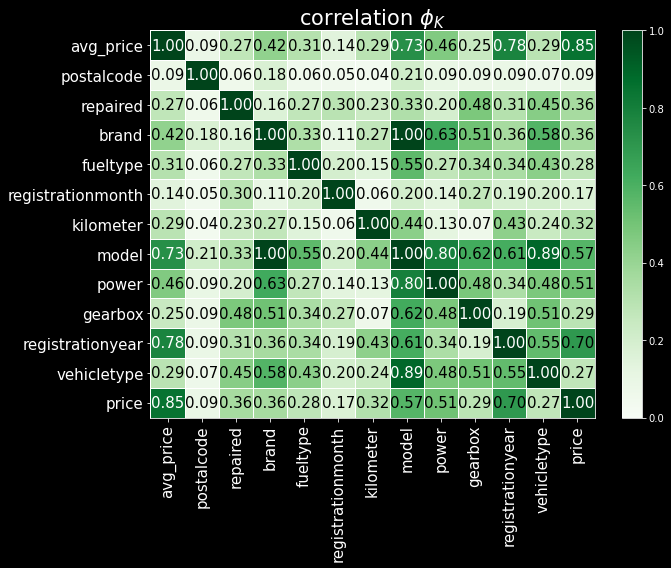

In [34]:
plot_correlation_matrix(phik_overview.values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map="Greens", 
                        title=r"correlation $\phi_K$", 
                        fontsize_factor=1.5, 
                        figsize=(10, 8))
plt.tight_layout()

больше всего цена коррелирует с registrationyear, model, power и repaired. postcode слабо влияет на цену, поэтому от этой колонки лучше избавиться

In [35]:
df.drop(['postalcode'], axis=1, inplace=True)
df.drop(['avg_price'], axis = 1, inplace = True) 

In [36]:
df

,price,vehicletype,registrationyear,gearbox,power,model,kilometer,registrationmonth,fueltype,brand,repaired
0,480.000000,unknown,1993,manual,104.777186,golf,150000,0,petrol,volkswagen,unknown
1,18300.000000,coupe,2011,manual,190.000000,unknown,125000,5,gasoline,audi,yes
2,9800.000000,suv,2004,auto,163.000000,grand,125000,8,gasoline,jeep,unknown
3,1500.000000,small,2001,manual,75.000000,golf,150000,6,petrol,volkswagen,no
4,3600.000000,small,2008,manual,69.000000,fabia,90000,7,gasoline,skoda,no
...,...,...,...,...,...,...,...,...,...,...,...
354364,2473.589474,unknown,2005,manual,104.777186,colt,150000,7,petrol,mitsubishi,yes
354365,2200.000000,unknown,2005,unknown,104.777186,unknown,20000,1,unknown,sonstige_autos,unknown
354366,1199.000000,convertible,2000,auto,101.000000,fortwo,125000,3,petrol,smart,no
354367,9200.000000,bus,1996,manual,102.000000,transporter,150000,3,gasoline,volkswagen,no


In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 347308 entries, 0 to 354368
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   price              347308 non-null  float64
 1   vehicletype        347308 non-null  object 
 2   registrationyear   347308 non-null  int64  
 3   gearbox            347308 non-null  object 
 4   power              347308 non-null  float64
 5   model              347308 non-null  object 
 6   kilometer          347308 non-null  int64  
 7   registrationmonth  347308 non-null  int64  
 8   fueltype           347308 non-null  object 
 9   brand              347308 non-null  object 
 10  repaired           347308 non-null  object 
dtypes: float64(2), int64(3), object(6)
memory usage: 31.8+ MB


итоговые данные получились размера 347354 на 11, много категориальных признаков, более или менее вычистили все неиформативные признаки и аномалии в данных. 

# modeling

какие модели планируется использовать: 

1. ridge регрессия 
2. carboost 
3. LightGBM

In [38]:
df.head()

,price,vehicletype,registrationyear,gearbox,power,model,kilometer,registrationmonth,fueltype,brand,repaired
0,480.0,unknown,1993,manual,104.777186,golf,150000,0,petrol,volkswagen,unknown
1,18300.0,coupe,2011,manual,190.000000,unknown,125000,5,gasoline,audi,yes
2,9800.0,suv,2004,auto,163.000000,grand,125000,8,gasoline,jeep,unknown
3,1500.0,small,2001,manual,75.000000,golf,150000,6,petrol,volkswagen,no
4,3600.0,small,2008,manual,69.000000,fabia,90000,7,gasoline,skoda,no


In [39]:
#подготовим выборки для обучения  
features = df.drop(['price'], axis=1)
target = df['price']

X_train, X_test, y_train, y_test = train_test_split(
    features, target, test_size=0.25, random_state=RANDOM_STATE)

## ridge regression

так как у заказчика одним из критериев отбора модели явлется время, логично предположить, что лучше, чтобы модели быстро обучались. 

для этого не стоит плодить признаки, например, моделей большое количество. 
здесь я решил пожертвовать некоторой точностью, чтобы получить прирост по времени, так как сложность алгоритма np^2

In [40]:
#трансформер 

#категориальные признаки для OHE Ridge
ohe_features_ridge = X_train.select_dtypes(include='object').columns.to_list()
#ohe_features_ridge.remove('model')
#численные признаки
num_features = X_train.select_dtypes(exclude='object').columns.to_list()

col_transformer_ridge = make_column_transformer(
    (
        OneHotEncoder(drop='first', handle_unknown='ignore'),
        ohe_features_ridge
    ),
    (
        StandardScaler(), 
        num_features
    ),
    remainder='passthrough',
    verbose_feature_names_out=False
)

In [41]:
%%time 
#зафиксируем время пайплайна обучения модели 

X_train_ridge = X_train.copy()
X_test_ridge = X_test.copy()

#чтобы уменьшить время
enc = OrdinalEncoder(handle_unknown = 'use_encoded_value', unknown_value = 999)
enc.fit(X_train_ridge[['model']])
X_train_ridge[['model']] = enc.transform(X_train_ridge[['model']])
X_test_ridge[['model']] = enc.transform(X_test_ridge[['model']])


model_ridge = Ridge(random_state=RANDOM_STATE)

pipeline_ridge = make_pipeline(col_transformer_ridge, model_ridge)

param_grid_ridge = {'ridge__alpha': np.arange(0, 0.21, 0.01)}

gs_ridge_pl = GridSearchCV(
    pipeline_ridge, cv = 3, 
    param_grid=param_grid_ridge, 
    scoring='neg_root_mean_squared_error', 
    n_jobs=-1
)

gs_ridge_pl.fit(X_train_ridge, y_train)

gs_ridge_best_score = gs_ridge_pl.best_score_ * -1
gs_ridge_best_params = gs_ridge_pl.best_params_

# лучшее значение RMSE на кросс-валидации
print(f'best_score: {gs_ridge_best_score}')
# лучшие гиперпараметры
print(f'best_params: {gs_ridge_best_params}')

best_score: 2486.803634595835
best_params: {'ridge__alpha': 0.17}
CPU times: user 7.82 s, sys: 1.77 s, total: 9.59 s
Wall time: 1min 24s


In [42]:
%%time 
pred = gs_ridge_pl.predict(X_train_ridge)


2482.6251552011017
CPU times: user 776 ms, sys: 92.7 ms, total: 868 ms
Wall time: 859 ms


### показатели модели

In [43]:
%%time 
#замерим время обучения модели с лучшими параметрами
ridge_best = Ridge(random_state=RANDOM_STATE, alpha = gs_ridge_pl.best_params_['ridge__alpha'])
pipeline_ridge_best = make_pipeline(col_transformer_ridge, ridge_best)
pipeline_ridge_best.fit(X_train_ridge, y_train)


CPU times: user 2.63 s, sys: 1.42 s, total: 4.04 s
Wall time: 2.77 s


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['vehicletype', 'gearbox',
                                                   'model', 'fueltype', 'brand',
                                                   'repaired']),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  ['registrationyear', 'power',
                                                   'kilometer',
                                                   'registrationmonth'])],
                                   verbose_feature_names_out=False)),
                ('ridge', Ridge(alpha=0.17, random_state=42))])

In [55]:
%%time
pred_best_model = pipeline_ridge_best.predict(X_train_ridge)

CPU times: user 427 ms, sys: 8.98 ms, total: 436 ms
Wall time: 431 ms


In [58]:
##RMSE
cross_val_score(pipeline_ridge_best, X_train_ridge, y_train,
                cv = 3, scoring = 'neg_root_mean_squared_error' ).mean() * -1


2486.847509374489

ну не очень точно, да, зато быстро, обучение почти не занимает времени, можно поробовать более сложные модели

## CTB

In [45]:
%%time 

X_train_ctb = X_train.copy()
X_test_ctb = X_test.copy()

catf = ohe_features_ridge.copy()
catf = catf + ['model']

model = CatBoostRegressor(loss_function="RMSE", verbose=False)

train_dataset = Pool(data=X_train_ctb, label=y_train , cat_features= catf)

grid = {'learning_rate': [0.03, 0.1],
        'depth': [4, 6, 8],
        'l2_leaf_reg': [1, 3, 5], 
        'iterations': [50, 75, 100]}

model.randomized_search(grid,train_dataset, cv =3,  verbose = False)

print(model.best_score_)


bestTest = 1974.898529
bestIteration = 49


bestTest = 2726.968638
bestIteration = 49


bestTest = 2146.545483
bestIteration = 99


bestTest = 1856.337795
bestIteration = 99


bestTest = 1869.541925
bestIteration = 49


bestTest = 2179.008881
bestIteration = 74


bestTest = 1767.831445
bestIteration = 99


bestTest = 2520.595879
bestIteration = 49


bestTest = 1793.436165
bestIteration = 49


bestTest = 1737.018908
bestIteration = 74

Training on fold [0/3]

bestTest = 1738.009255
bestIteration = 74

Training on fold [1/3]

bestTest = 1749.848429
bestIteration = 74

Training on fold [2/3]

bestTest = 1741.703882
bestIteration = 74

{'learn': {'RMSE': 1723.3608122566527}}
CPU times: user 2min 6s, sys: 5.95 s, total: 2min 12s
Wall time: 1min 32s


### показатели модели с наилучшими параметрами

In [46]:
param = model.get_params()

In [63]:
%%time
#время обучения 
model_ctb_best = CatBoostRegressor(**param, cat_features=catf)
model_ctb_best.fit(train_dataset)

CPU times: user 14.6 s, sys: 425 ms, total: 15.1 s
Wall time: 11.6 s


In [64]:
%%time 
#время предсказания
ctb_best_predict = model_ctb_best.predict(train_dataset)


CPU times: user 135 ms, sys: 31.6 ms, total: 167 ms
Wall time: 141 ms


In [65]:
#RMSE 
cross_val_score(model_ctb_best, X_train_ctb, y_train,  
                cv = 3, scoring = 'neg_root_mean_squared_error' ).mean() * -1


1741.8826586574535

кэтбуст конечно подольше обучается, чем модель ридж регрессия, но выдает лучше результаты на этом датасете. 

некоторого ускорения можно добиться, если вместо grid_search поставить random_serach, тогда перебор идет быстрее. 

## lightgbm

In [49]:
%%time
X_train_lgbm = X_train.copy()
X_test_lgbm = X_test.copy()

enc = OrdinalEncoder(handle_unknown = 'use_encoded_value', unknown_value = 999)
X_train_lgbm[catf] = enc.fit_transform(X_train_lgbm[catf])
X_test_lgbm[catf] = enc.transform(X_test_lgbm[catf])

lgb_model = lgb.LGBMRegressor(objective = 'root_mean_squared_error',)

grid = {
  'learning_rate': [0.03, 0.1],
  'max_depth': [4, 6, 8],
  'reg_lambda': [0.3, 0.5, 0.7],
  'n_estimators': [100, 120, 150]}

lgb_model_search = RandomizedSearchCV(lgb_model, grid, scoring='neg_mean_squared_error', cv =3)
lgb_model_search.fit(X_train_lgbm, y_train, categorical_feature=catf )



CPU times: user 1min 53s, sys: 486 ms, total: 1min 53s
Wall time: 1min 5s


RandomizedSearchCV(cv=3,
                   estimator=LGBMRegressor(objective='root_mean_squared_error'),
                   param_distributions={'learning_rate': [0.03, 0.1],
                                        'max_depth': [4, 6, 8],
                                        'n_estimators': [100, 120, 150],
                                        'reg_lambda': [0.3, 0.5, 0.7]},
                   scoring='neg_mean_squared_error')

In [50]:
%%time 
print(mean_squared_error(lgb_model_search.predict(X_train_lgbm), y_train, squared = False))

1543.1773822890905
CPU times: user 3.71 s, sys: 6.37 ms, total: 3.72 s
Wall time: 2.32 s


### параметры лучшей модели

In [51]:
params = lgb_model_search.best_params_

In [66]:
%%time 
#время обучения
lgb_model_best = lgb.LGBMRegressor(**params)
lgb_model_best.fit(X_train_lgbm, y_train)


CPU times: user 4.39 s, sys: 21.8 ms, total: 4.42 s
Wall time: 2.83 s


LGBMRegressor(max_depth=6, n_estimators=150, reg_lambda=0.3)

In [67]:
%%time
#время предсказания 
pred = lgb_model_best.predict(X_train_lgbm)

CPU times: user 2.97 s, sys: 525 µs, total: 2.97 s
Wall time: 2.89 s


In [68]:
#RMSE 
cross_val_score(lgb_model_best, X_train_lgbm, y_train,  
                cv = 3, scoring = 'neg_root_mean_squared_error' ).mean() * -1


1679.242551666437

# выводы 

## про датасет: 

  в датасете много аномалий, поэтому пришлось прибегнуть к некоторым ухищрениям, чтобы исправить их. 

## про модели: 

### сравнение по качеству: 

лучше всего на тестовой выборке показала себя lgb_model, но вполне соизмерима с катбустом. ridge регрсессия показала результаты хуже минимального порога в 2500. 

### сравнение по скорости обучения: 

тут бесспорный лидер ridge-регрессия, но из-за качества можно вынести ее за скобки и сравнивать между собой бустинги. 


### сравнение по скорости предсказания на тестовой выборке: 

немного лучше предсказывает lightGBM, но дольше, чем catboost. 

#итог:

для работы с такими даннными я бы взял катбуст и немного еще поработал над возможными парамтерами, чтобы улучшить точность. 

CTB:

- Wall time: 11.6 s -- обучение 
- Wall time: 141 ms -- предикт
- 1741.8826586574535 -- RMSE 

LGBM:

- Wall time: 2.83 s -- обучение 
- Wall time: 2.89 s -- предикт
- 1679.242551666437 -- RMSE 




# тест итоговой модели 

лучшая модель по совокупности факторов: скорость обучения, сокрость предсказания, качество -- кэтбуст. 

In [54]:
%%time 

#проверим, что модель показывает такой же результат на тестовой выборке 
test_dataset = Pool(data=X_test_ctb, label=y_test , cat_features= catf)

print(mean_squared_error(model.predict(test_dataset), y_test, squared = False))

1708.487230317826
CPU times: user 194 ms, sys: 29.9 ms, total: 224 ms
Wall time: 219 ms
